# Run to install and import required packages

In [ ]:
!pip install pdf2image reportlab daltonlens > /dev/null
!apt install poppler-utils > /dev/null
!git clone https://github.com/jgmatt/color-accessibility-checker.git > /dev/null
import sys
sys.path.insert(0,'/content/color-accessibility-checker')
from utils import upload_files, settings_widgets, process_and_display
print("Successfully installed and imported all required packages!")

# Upload your figure here

Make sure your figure is in one of the following formats:
- .pdf
- .jp(e)g
- .png

In [2]:
upload_widget = upload_files()

FileUpload(value={}, accept='.pdf,.jpg,.jpeg,.png,', description='Upload', multiple=True)

# Choose settings here

In [3]:
cb_type_widget, severity_widget, pdf_page_widget = settings_widgets()
display(cb_type_widget, severity_widget, pdf_page_widget)

Dropdown(description='CB Type:', options=('deuteranopia', 'protanopia', 'tritanopia', 'grayscale'), style=Desc…

FloatSlider(value=1.0, description='Severity:', max=1.0, step=0.01, style=SliderStyle(description_width='initi…

IntText(value=7, description='PDF Page:', style=DescriptionStyle(description_width='initial'))

# Run to process your image

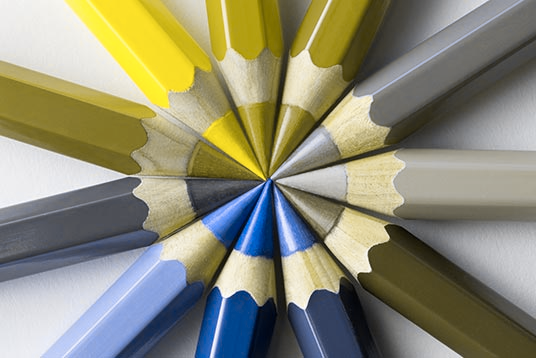

In [7]:
process_and_display(upload_widget, cb_type_widget, severity_widget, pdf_page_widget)